In [1]:
import sys
import os
import wandb
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from wandb.keras import WandbCallback

from data import*
from sklearn.model_selection import KFold
import tensorflow as tf

from tensorflow.keras.models import load_model
model = load_model("./output/ThreeLevel_CT_Inhouse_USC_opti_exp_1.hdf5")
sys.path.append(os.getcwd()+'/code')

2022-03-22 17:20:33.377817: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-22 17:20:33.419433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-22 17:20:33.420064: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-03-22 17:20:33.424446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-22 17:20:33.428570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-03-22 17:20:33.429090: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [2]:
import sys
#print(sys.path)
print(len(model.layers))

39


In [3]:
#parameters and variables
num_ep = 100
num_step = 50
num_layers = 25
model_loc = './output/ThreeLevel_optimization_airway_sweep_exp1.hdf5'
output_loc = './NetworkOutput/ThreeLevel_optimization_airway_sweep_Radial/'
#wandb.init(project='twolevel-1000ep-50st-15l', entity="subinek")

train_loc = './data/Radial/Train/'
train_large_loc = '/home/erattakulangara/hpchome/DeepLearningAlgo/2021_T2_T1_Airway_Segmentation/data/train/Airway/'
val_loc = './data/Radial/Val/'
test_loc = './data/Radial/Test/Image/'

In [4]:
if not os.path.exists(output_loc):
    os.makedirs(output_loc)
    print('done')

## sweep config

In [5]:
sweep_config = {
    'method': 'grid',
    'metric':{
        'name':'loss',
        'goal':'minimize'
    },
    'parameters':{
        'epochs':{
            'values':[60,250,500]
        },
        'steps_per_epoch':{
            
            'values':[100,150]
        },
        'num_layers':{
            'values':[18,20,22,24,25,27,29,30,32,34,36]
        },
        'learning_rate': {
            'values': [ 1e-4,1e-5,1e-3]
        },
        'optimizer':{
            'values':['adam']
        }
        
    }
}

sweep_id = wandb.sweep(sweep_config, entity="subinek", project = "three-level-sweep-radial")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: cqxb1gvj
Sweep URL: https://wandb.ai/subinek/three-level-sweep-radial/sweeps/cqxb1gvj


In [6]:
def train():
        #define the default config
    config_defaults = {
        'epochs':60,
        'steps_per_epoch':100,
        'optimizer': 'adam',
        'learning_rate': 1e-4,
        'num_layers':20
    }
    
    wandb.init(config = config_defaults)
    config = wandb.config
    

    
    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(lr=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(lr=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    
    for i in range(0,config.num_layers):
        model.layers[i].trainable = False
    
    for i in range(config.num_layers,len(model.layers)):
        model.layers[i].trainable = True


    
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    fill_mode='nearest')
    myGene = trainGenerator(2,train_loc,'Image','Airway',data_gen_args,save_to_dir = None)
    myVal = trainGenerator(2,val_loc,'Image','Airway',data_gen_args,save_to_dir = None)
    
    model_checkpoint = ModelCheckpoint(model_loc, monitor='loss',verbose=1, save_best_only=True)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, 
                                       verbose=1, mode='auto', min_lr=0.0001)
    
    model.fit_generator(myGene,validation_data = myVal,validation_steps = 1,steps_per_epoch=config.steps_per_epoch,epochs=config.epochs,callbacks=[model_checkpoint, reduce_lr, WandbCallback()])

In [ ]:
wandb.agent(sweep_id,train)

wandb: Agent Starting Run: 3kctlxl0 with config:
wandb: 	epochs: 60
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 18
wandb: 	optimizer: adam
wandb: 	steps_per_epoch: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: subinek (use `wandb login --relogin` to force relogin)
/home/erattakulangara/.conda/envs/chestXSeg/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Instructions for updating:
Please use Model.fit, which supports generators.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Epoch 1/60


2022-03-22 17:20:55.744039: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-03-22 17:21:01.176652: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


100/100 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9909Found 3 images belonging to 1 classes.
Found 3 images belonging to 1 classes.

Epoch 00001: loss improved from inf to 0.02476, saving model to ./output/ThreeLevel_optimization_airway_sweep_exp1.hdf5
100/100 [==============================] - 10s 100ms/step - loss: 0.0248 - accuracy: 0.9909 - val_loss: 0.2863 - val_accuracy: 0.9461 - lr: 1.0000e-04
Epoch 2/60
100/100 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9945
Epoch 00002: loss improved from 0.02476 to 0.01299, saving model to ./output/ThreeLevel_optimization_airway_sweep_exp1.hdf5
100/100 [==============================] - 7s 68ms/step - loss: 0.0130 - accuracy: 0.9945 - val_loss: 0.3253 - val_accuracy: 0.9490 - lr: 1.0000e-04
Epoch 3/60
100/100 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9956
Epoch 00003: loss improved from 0.01299 to 0.01030, saving model to ./output/ThreeLevel_optimization_

Epoch 24/60
100/100 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9975
Epoch 00024: loss improved from 0.00567 to 0.00556, saving model to ./output/ThreeLevel_optimization_airway_sweep_exp1.hdf5
100/100 [==============================] - 7s 70ms/step - loss: 0.0056 - accuracy: 0.9975 - val_loss: 0.3760 - val_accuracy: 0.9584 - lr: 1.0000e-04
Epoch 25/60
100/100 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9975
Epoch 00025: loss did not improve from 0.00556
100/100 [==============================] - 5s 55ms/step - loss: 0.0056 - accuracy: 0.9975 - val_loss: 0.2225 - val_accuracy: 0.9710 - lr: 1.0000e-04
Epoch 26/60
100/100 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9976
Epoch 00026: loss improved from 0.00556 to 0.00543, saving model to ./output/ThreeLevel_optimization_airway_sweep_exp1.hdf5
100/100 [==============================] - 7s 69ms/step - loss: 0.0054 - accuracy: 0.9976 - val_loss: 0.5009 - val_a

100/100 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9979
Epoch 00049: loss improved from 0.00489 to 0.00479, saving model to ./output/ThreeLevel_optimization_airway_sweep_exp1.hdf5
100/100 [==============================] - 7s 68ms/step - loss: 0.0048 - accuracy: 0.9979 - val_loss: 0.6775 - val_accuracy: 0.9402 - lr: 1.0000e-04
Epoch 50/60
100/100 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9978
Epoch 00050: loss did not improve from 0.00479
100/100 [==============================] - 5s 54ms/step - loss: 0.0049 - accuracy: 0.9978 - val_loss: 0.2706 - val_accuracy: 0.9684 - lr: 1.0000e-04
Epoch 51/60
100/100 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9979
Epoch 00051: loss did not improve from 0.00479
100/100 [==============================] - 5s 54ms/step - loss: 0.0049 - accuracy: 0.9979 - val_loss: 0.6618 - val_accuracy: 0.9415 - lr: 1.0000e-04
Epoch 52/60
100/100 [==============================] - E

accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▃█▂▅▃▃▆▂▄▇▇▇█▄▅▇▃▃▇▄▂▇▆▅▇█▅▅▅▂▄▁▆▂▅▁▆▂▂
val_loss,▃▃▁▅▃▅▅▃▆▄▂▂▂▁▄▄▂▆▅▂▅▆▃▃▄▂▂▄▄▄▆▆█▃▇▄▇▄▇█
accuracy,0.99801
best_epoch,8
best_val_loss,0.04319
epoch,59
loss,0.00454


wandb: Agent Starting Run: 6b17x0jr with config:
wandb: 	epochs: 60
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 18
wandb: 	optimizer: adam
wandb: 	steps_per_epoch: 150
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Epoch 1/60
150/150 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9979Found 3 images belonging to 1 classes.
Found 3 images belonging to 1 classes.

Epoch 00001: loss improved from inf to 0.00476, saving model to ./output/ThreeLevel_optimization_airway_sweep_exp1.hdf5
150/150 [==============================] - 11s 76ms/step - loss: 0.0048 - accuracy: 0.9979 - val_loss: 0.7317 - val_accuracy: 0.9389 - lr: 1.0000e-04
Epoch 2/60
150/150 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9979
Epoch 00002: loss improved from 0.00476 to 0.00464, saving model to ./output/ThreeLevel_optimization_airway_sweep_exp1.hdf5
150/150 [==============================] - 11s 71ms/step - loss: 0.0046 - accuracy: 0.9979 - val_loss: 0.7019 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 3/60
150/150 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9980
Epoch 0000

150/150 [==============================] - 9s 62ms/step - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.3506 - val_accuracy: 0.9575 - lr: 1.0000e-04
Epoch 25/60
150/150 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9981
Epoch 00025: loss did not improve from 0.00421
150/150 [==============================] - 8s 54ms/step - loss: 0.0043 - accuracy: 0.9981 - val_loss: 0.2062 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 26/60
150/150 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9981
Epoch 00026: loss did not improve from 0.00421
150/150 [==============================] - 8s 54ms/step - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.5172 - val_accuracy: 0.9412 - lr: 1.0000e-04
Epoch 27/60
150/150 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9981
Epoch 00027: loss improved from 0.00421 to 0.00417, saving model to ./output/ThreeLevel_optimization_airway_sweep_exp1.hdf5
150/150 [==============================] - 9

In [14]:
# save the history file
import pandas as pd
hist_df = pd.DataFrame(h.history) 

# save to json:  
hist_json_file = 'Airway_Trans_131img_200epoch_30layers_val_lossMetric_lr=108.hdf5.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

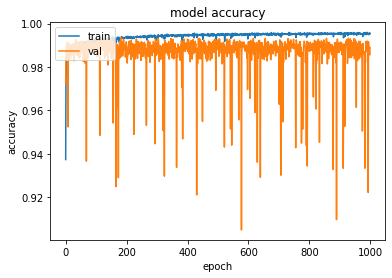

<Figure size 432x288 with 0 Axes>

In [15]:
#plotting model accuracy

from matplotlib import pyplot as plt
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('Airway_Trans_131img_200epoch_30layers_val_lossMetric_lr=108.hdf5.png')

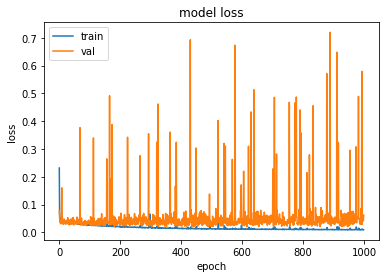

<Figure size 432x288 with 0 Axes>

In [16]:
#plotting the model loss

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('Airway_Trans_131img_200epoch_30layers_val_lossMetric_lr=108.hdf5.png')

# Testing the Generated models

# 1 ) U-net model

In [1]:

from tensorflow.keras.models import load_model
model_loc_new = './output/Storm_Best_Model.h5'
output_loc = './NetworkOutput/ThreeLevel_optimization_airway_sweep_Storm/'
test_loc = './data/Storm/Test/Image/'
model = load_model(model_loc_new)

2022-03-11 10:29:16.564917: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-11 10:29:16.581104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-11 10:29:16.581384: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-03-11 10:29:16.584588: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-03-11 10:29:16.587788: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-03-11 10:29:16.588213: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

In [ ]:
# test module is been uploaded from the data.py file
import sys
import os
sys.path.append(os.getcwd()+'/code')

from data import*

test_generator = testGenerator(test_loc,0,19,target_size=(256,256))
output = model.predict_generator(test_generator,19,verbose=1)
saveResult(output_loc,output)

In [2]:
os.getcwd()

NameError: name 'os' is not defined

In [ ]:
DeepLearningAlgo/2021_T2_T1_Airway_Segmentation/data/test/zanaza_two_subjects/subje